#0 Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import zipfile
import os
import glob
import re
from datetime import timedelta

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# 1 Fatility Data Cleaning  
This part cleaned the dataset `csse_covid_19_daily_reports_us` folder.
## 1.1 Incorporating data from multiple files   
The `csse_covid_19_daily_reports_us` folder contains the daily case reports of each USA State level data. The data of each day is saved in a unique CSV file. This step aggregated the data of all CSV files in this folder into one single dataframe.

In [2]:
abspath = os.path.abspath(os.pardir)

datafolder = 'data/'

datapath = os.path.join(abspath, datafolder)
# datapath = '/content/drive/MyDrive/DataC200 Graduate Project/Dataset/'
covid19_daily_report_folder = 'csse_covid_19_daily_reports_us'

files = os.path.join(datapath, covid19_daily_report_folder, '*.csv')

# list of merged files returned
files = glob.glob(files)

daily_report = pd.DataFrame()
for i in files:
  df = pd.read_csv(i, index_col=0)
#  df['Last_Update'] = pd.to_datetime(df['Last_Update'])
# The date of each data CSV is the previous day of `Last_Update` column
  df['date'] = i[-14:-4]
  df['date'] = pd.to_datetime(df['date'])
  daily_report = pd.concat([daily_report, df], axis=0)

daily_report.reset_index(inplace=True)

## 1.2 Dropping States with Less Interest  
There are records of some states that are not actually 'States' or of less interest, but containing a lot of missing values, such as `Diamond Princess`, `Recovered`, etc. The records of these states were dropped in this step to keep the data formal.

In [3]:
daily_report['Province_State'].unique()

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia',
       'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virgin Islands', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Recovered'], dtype=object)

In [4]:
print('Shape before dropping states with less interest :',daily_report.shape)
daily_report = daily_report[~daily_report['Province_State'].isin(['American Samoa','Diamond Princess','Grand Princess', 
                                                     'Guam','Northern Mariana Islands','Puerto Rico', 'Rhode Island','Recovered'])]
print('Shape after dropping states with less interest :',daily_report.shape)


Shape before dropping states with less interest : (42764, 21)
Shape after dropping states with less interest : (37587, 21)


##1.3 Selecting the Time Window for Modeling  
The original dataset contains data from 2020-04-11 to 2022-04-18. However, after exploring, we found that data in the early period contains a lot of null values, especially in our key column of interest `Case_Fatality_Ratio`,which could cause problems in the modeling step. Thus the time window for modeling is selected as '2021-04-01' to '2022-04-01'.

In [5]:
print('Earliest date in dataset: ',daily_report['date'].min())
print('Latest date in dataset: ',daily_report['date'].max())

Earliest date in dataset:  2020-04-12 00:00:00
Latest date in dataset:  2022-04-18 00:00:00


In [6]:
# The proportion of null values in each column
daily_report.isna().sum()/len(daily_report)

Province_State          0.000000
Country_Region          0.000000
Last_Update             0.000027
Lat                     0.000000
Long_                   0.000000
Confirmed               0.000000
Deaths                  0.000000
Recovered               0.629446
Active                  0.629446
FIPS                    0.000027
Incident_Rate           0.000000
Total_Test_Results      0.296352
People_Hospitalized     0.868971
Case_Fatality_Ratio     0.286296
UID                     0.000000
ISO3                    0.000000
Testing_Rate            0.010057
Hospitalization_Rate    0.868971
date                    0.000000
People_Tested           0.713704
Mortality_Rate          0.713704
dtype: float64

In [7]:
daily_report = daily_report.loc[(daily_report['date']>='2021-04-01')&(daily_report['date']<='2022-04-01')].sort_values(['Province_State','date'])
daily_report.isna().sum()/len(daily_report)

Province_State          0.000000
Country_Region          0.000000
Last_Update             0.000000
Lat                     0.000000
Long_                   0.000000
Confirmed               0.000000
Deaths                  0.000000
Recovered               1.000000
Active                  1.000000
FIPS                    0.000000
Incident_Rate           0.000000
Total_Test_Results      0.010715
People_Hospitalized     1.000000
Case_Fatality_Ratio     0.000000
UID                     0.000000
ISO3                    0.000000
Testing_Rate            0.010715
Hospitalization_Rate    1.000000
date                    0.000000
People_Tested           1.000000
Mortality_Rate          1.000000
dtype: float64

##1.3 Filling Null Values in Testing_Rate Column  
After the previous manipulation, the Case_Fatality_Ratio contains no more missing values, but there are certain amounts of missing data in Testing_Rate column. 

Compared to total data records, the missing amount is relatively small, so we will fill NaN values using an interpolation method. From scatterplot inspection we see the tesing rate appear to be linear, so we will use Linear Interpolation method to fill null values.

Number of null values in Testing_Rate before filling:  200
Number of null values in Testing_Rate after filling:  0


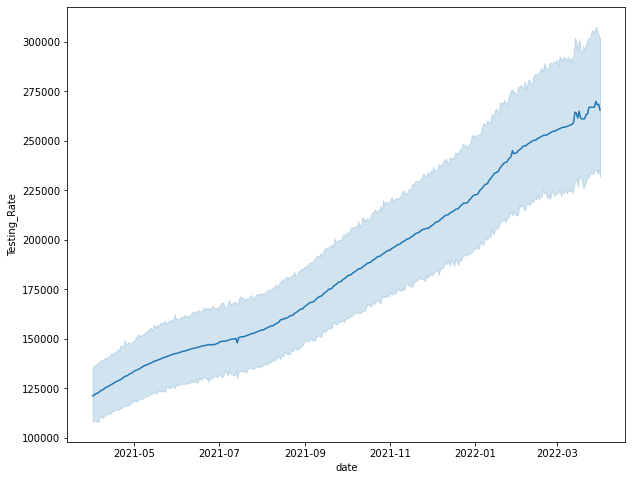

In [8]:
# data=daily_report.loc[daily_report['Province_State']=='California']
print('Number of null values in Testing_Rate before filling: ',daily_report['Testing_Rate'].isna().sum())
plt.figure(figsize=(10,8))
sns.lineplot(data=daily_report, x='date', y='Testing_Rate')
daily_report['Testing_Rate'] = daily_report['Testing_Rate'].interpolate(method='linear')
print('Number of null values in Testing_Rate after filling: ',daily_report['Testing_Rate'].isna().sum())

##1.4 Scaling Testing_Rate and Incident_Rate
The original values of Testing_Rate and Incident_Rate are count per 100,000 persons. We need to moldify them to become of same scale with other ratios (count per 100 persons).
    
**It is worth mentioning that there seems to be some data errors in the `Testing_Rate` column. The maxium of that column should not exceed 100,000, but it turns out that the maximum of that column is around 600,000. We kept that in mind for now and would see if it could be a problem in the following modeling steps.**

In [9]:
daily_report['Testing_Rate'].sort_values()

11547     13788.122517
29554     37829.849502
4946      37894.256784
4888      37959.111728
21486     37959.111728
             ...      
3389     608283.594508
16797    610898.638709
22481    612489.294528
22539    613023.469123
32115    613862.351601
Name: Testing_Rate, Length: 18666, dtype: float64

In [10]:
daily_report['Testing_Rate'] = daily_report['Testing_Rate']/1000
daily_report['Incident_Rate'] = daily_report['Incident_Rate']/1000

#2 Vaccination Data Cleaning
This part cleaned the dataset `COVID-19_Vaccination_Trends_in_the_United_States_National_and_Jurisdictional`, which is an external dataset we linked in this project. it is the overall Trends in Number of COVID-19 Vaccinations in the US at national and jurisdictional levels.  
  
Data Source: https://data.cdc.gov/Vaccinations/COVID-19-Vaccination-Trends-in-the-United-States-N/rh2h-3yt2

##2.1 Converting postal state names to full names  
In the `csse_covid_19_daily_reports_us` dataset which was just cleaned in the previous part, it uses the full name to represent the states of US, such as `California`, but in the `COVID-19_Vaccination_Trends_in_the_United_States_National_and_Jurisdictional` dataset, it uses postal names, such as `CA`. This step converted the postal state names to full names, and also drop states of less interest as we did in the previous part.

In [11]:
vac_path = datapath + 'COVID-19_Vaccination_Trends_in_the_United_States_National_and_Jurisdictional.csv'
vac_path

'/Users/guangyaoli/Downloads/3036336718_3036339721 3/data/COVID-19_Vaccination_Trends_in_the_United_States_National_and_Jurisdictional.csv'

In [12]:
vac_path = datapath + 'COVID-19_Vaccination_Trends_in_the_United_States_National_and_Jurisdictional.csv'
daily_vac = pd.read_csv(vac_path)
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming',
    'VI': 'Virgin Islands'
}

daily_vac.rename(columns={'Location':'Province_State','Date':'date'},inplace=True)
daily_vac['Province_State'].replace(states, inplace=True)
daily_vac = daily_vac[daily_vac['Province_State'].isin(daily_report['Province_State'])]
daily_vac['Province_State'].unique().sort() == daily_report['Province_State'].unique().sort()

True

##2.2 Converting `date` to datetime format

In this step, we also selected the time widow for modeling as we did in the previous part for consistency.

In [13]:
daily_vac['date'] = pd.to_datetime(daily_vac['date'])
daily_vac = daily_vac.loc[(daily_vac['date']>='2021-04-01')&(daily_vac['date']<='2022-04-01')].sort_values(['Province_State','date'])

##2.3 Checking Missing Values  
The vaccination dataset contains no missing values, which is great.

In [14]:
daily_vac.isna().sum()

date                                         0
MMWR_week                                    0
Province_State                               0
Administered_Daily                           0
Administered_Cumulative                      0
Administered_7_Day_Rolling_Average           0
Admin_Dose_1_Daily                           0
Admin_Dose_1_Cumulative                      0
Admin_Dose_1_Day_Rolling_Average             0
Administered_Dose1_Pop_Pct                   0
date_type                                    0
Administered_daily_change_report             0
Administered_daily_change_report_7dayroll    0
Series_Complete_Daily                        0
Series_Complete_Cumulative                   0
Series_Complete_Day_Rolling_Average          0
Series_Complete_Pop_Pct                      0
Booster_Daily                                0
Booster_Cumulative                           0
Booster_7_Day_Rolling_Average                0
Additional_Doses_Vax_Pct                     0
dtype: int64

##2.4 Dropping Duplicated Records of Each State Caused by Different Date Types

We found that this dataset contains duplicated daily records of each state, caused by different `date_type`.  

`date_type`	- Date of administration or date reported by CDC on COVID Tracker
  
Therefore, we kept only `Admin` type.


In [15]:
daily_vac.sort_values(by=['date','Province_State'])[['date','date_type','Province_State','Series_Complete_Pop_Pct']]

date date_type Province_State  Series_Complete_Pop_Pct
46070 2021-04-01     Admin        Alabama                     15.5
46082 2021-04-01    Report        Alabama                     13.7
46023 2021-04-01    Report         Alaska                     22.6
46029 2021-04-01     Admin         Alaska                     28.3
46059 2021-04-01     Admin        Arizona                     20.3
...          ...       ...            ...                      ...
2322  2022-04-01     Admin  West Virginia                     57.3
2232  2022-04-01     Admin      Wisconsin                     65.2
2236  2022-04-01    Report      Wisconsin                     65.1
2246  2022-04-01    Report        Wyoming                     51.1
2303  2022-04-01     Admin        Wyoming                     51.2

[37332 rows x 4 columns]

In [16]:
daily_vac = daily_vac.loc[(daily_vac['date_type']=='Admin')].sort_values(['Province_State','date'])

#3 Merging Datasets  
After cleaning both daily report dataset and daily vaccination dataset, we merged them together for the following EDA and modeling parts.

In [17]:
merged_df = daily_report.merge(daily_vac, how='inner', on=['Province_State','date'])
# save the file
merged_path = datapath + 'merged_df.csv'
# merged_df.to_csv(merged_path)

In [18]:
# Checking if there are any duplicates
print(len(merged_df[['date','Province_State','Series_Complete_Pop_Pct','Case_Fatality_Ratio','Incident_Rate','Testing_Rate']]))
print(len(merged_df[['date','Province_State','Series_Complete_Pop_Pct','Case_Fatality_Ratio','Incident_Rate','Testing_Rate']].drop_duplicates()))

18666
18666
